In [1]:
# configuring path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/time_series
!pwd

/content/drive/MyDrive/Colab Notebooks/time_series
/content/drive/MyDrive/Colab Notebooks/time_series


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [44]:
# Importing the Keras libraries and packages
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint,EarlyStopping

In [9]:
# load data
df = pd.read_csv('for_time_series_forceasting_pedestrian_count.tsv',sep='\t')
# dataframe hard copy for normalization
df_norm = df.copy()

original data


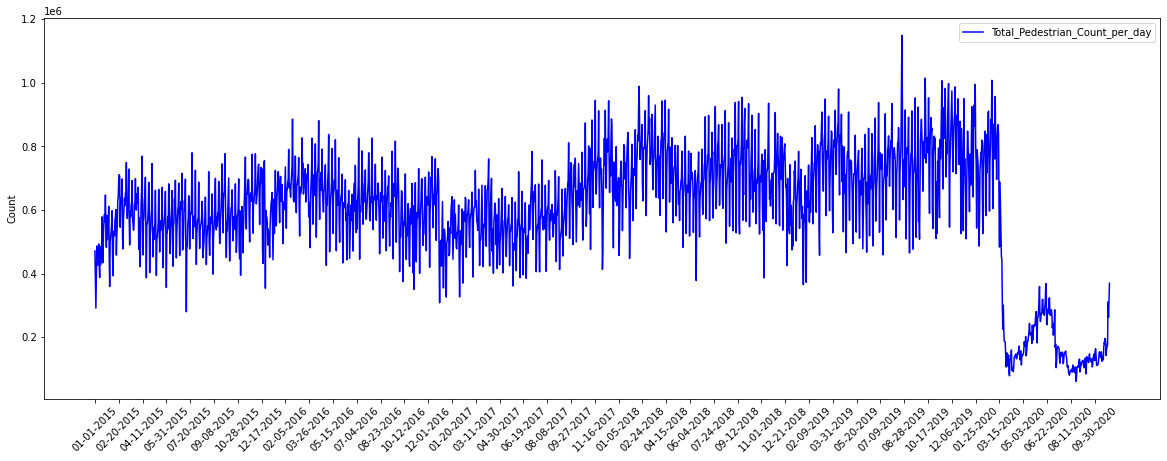

In [10]:
# show pedestrian count each day
print('original data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df)), df['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df),50),df['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()


Normalized data


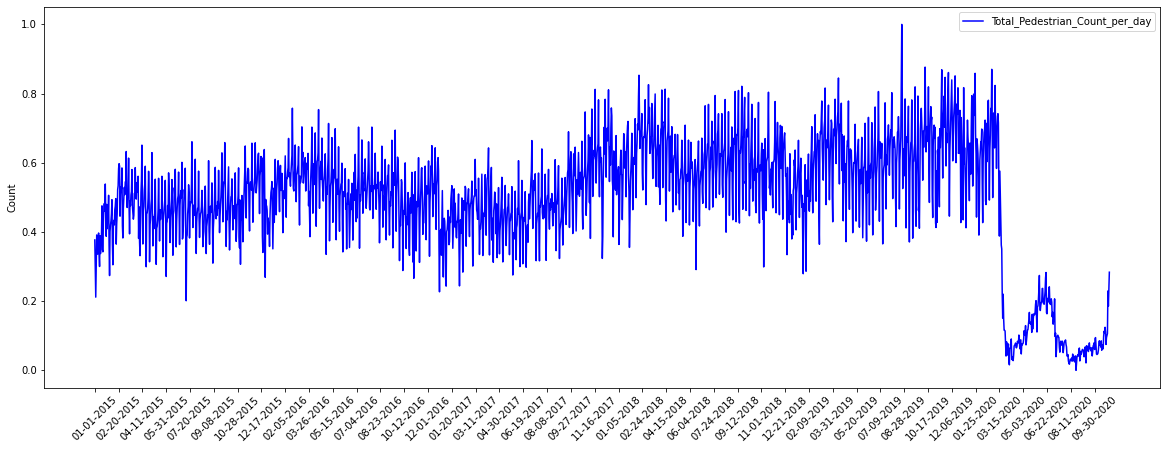

In [11]:
# Data Normalization
scaler = MinMaxScaler()
df_norm.iloc[:,1:] = scaler.fit_transform(df_copy.iloc[:,1:].values)    # normalize feature except the date column
# test_x.iloc[:, 1:] = scaler.transform(test_x.iloc[:, 1:].values)

print('\nNormalized data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df_norm)), df_norm['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df_norm),50),df_norm['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()

In [12]:
df_norm

,Date,Daily global solar exposure (MJ/m*m),Covid Restrictions,Rainfall amount (millimetres),Public_Holiday,Maximum temperature (Degree C),Minimum temperature (Degree C),Total_Pedestrian_Count_per_day
0,01-01-2015,0.702454,0.0,0.00000,1.0,0.518841,0.463504,0.376885
1,01-02-2015,0.800613,0.0,0.00000,0.0,0.863768,0.540146,0.301011
2,01-03-2015,0.791411,0.0,0.00000,0.0,0.846377,0.708029,0.211554
3,01-04-2015,0.751534,0.0,0.08042,0.0,0.359420,0.572993,0.294865
4,01-05-2015,0.920245,0.0,0.00000,0.0,0.376812,0.525547,0.391282
...,...,...,...,...,...,...,...,...
2127,10-27-2020,0.595092,1.0,0.00000,0.0,0.307246,0.383212,0.106274
2128,10-28-2020,0.797546,1.0,0.00000,0.0,0.344928,0.324818,0.229500
2129,10-29-2020,0.503067,1.0,0.00000,0.0,0.443478,0.386861,0.185415
2130,10-30-2020,0.622699,1.0,0.00000,0.0,0.278261,0.448905,0.231290


In [13]:
n_past = 150           # no of past days used to predict the future
n_future = 10         # no of future days being predicted


x_train = []
y_train = []

for i in range(n_past, len(df_norm)):
	x_train.append(df_norm.iloc[i-n_past:i, 1:].values) # use all column apart from date as feature
	y_train.append(df_norm.iloc[i,-1]) # considering last column as target label

x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1)
print('Train data shape: ', x_train.shape)
print('Train Target shape: ', y_train.shape)

Train data shape:  (1982, 150, 7)
Train Target shape:  (1982, 1)


In [14]:
# test on last N days
LAST_N_DAYS = 30

train_x = x_train[:-LAST_N_DAYS,:,:]
train_y = y_train[:-LAST_N_DAYS,:]
print('Train data shape: ', train_x.shape)
print('Train Target shape: ', train_y.shape)

test_x = x_train[-LAST_N_DAYS:,:,:]
test_y = y_train[-LAST_N_DAYS:,:]
print('Test data shape: ', test_x.shape)
print('Test Target shape: ', test_y.shape)

Train data shape:  (1952, 150, 7)
Train Target shape:  (1952, 1)
Test data shape:  (30, 150, 7)
Test Target shape:  (30, 1)


# Simple RNN

Add SimpleRNN model here

In [38]:
def get_model():
  np.random.seed(36)
  model = Sequential()
  model.add(SimpleRNN(50, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(512))
  model.add(Dropout(0.3))
  model.add(Dense(128))
  model.add(Dense(1))
  return model

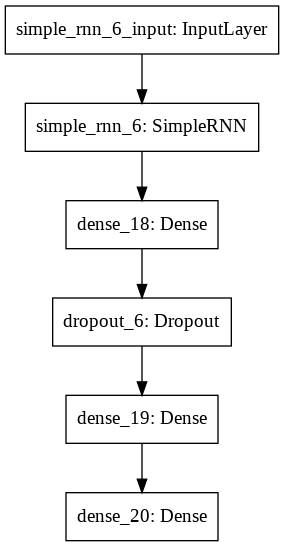

In [39]:
# Model Visualization
model = get_model()
plot_model(model)

In [40]:
model = get_model()
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, verbose=0, mode='min', min_delta=0.0001, min_lr=0.000000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.00001)

tensorboard = TensorBoard(log_dir="logs",write_graph=True)
filepath = './best_rnn_model.hdf5'
model_check_point = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

LR = 1e-4
EPOCH = 200
opt = Adam(lr=LR, decay=LR/EPOCH)
# opt = Adam(lr=LR)
# opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss='mae')

In [41]:
model_history = model.fit(
                            train_x, train_y, 
                            epochs=EPOCH, 
                            batch_size=128, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [reduce_lr_on_plateau, tensorboard, model_check_point,early_stopping]
                        )

Epoch 1/200
13/13 [==============================] - 4s 226ms/step - loss: 0.3947 - val_loss: 0.1340
Epoch 2/200
13/13 [==============================] - 2s 142ms/step - loss: 0.1791 - val_loss: 0.1485
Epoch 3/200
13/13 [==============================] - 2s 148ms/step - loss: 0.1537 - val_loss: 0.1199
Epoch 4/200
13/13 [==============================] - 2s 132ms/step - loss: 0.1306 - val_loss: 0.0938
Epoch 5/200
13/13 [==============================] - 2s 135ms/step - loss: 0.1272 - val_loss: 0.0764
Epoch 6/200
13/13 [==============================] - 2s 134ms/step - loss: 0.1231 - val_loss: 0.0693
Epoch 7/200
13/13 [==============================] - 2s 143ms/step - loss: 0.1145 - val_loss: 0.0651
Epoch 8/200
13/13 [==============================] - 2s 129ms/step - loss: 0.1100 - val_loss: 0.0756
Epoch 9/200
13/13 [==============================] - 2s 130ms/step - loss: 0.1083 - val_loss: 0.0925
Epoch 10/200
13/13 [==============================] - 2s 135ms/step - loss: 0.1076 - val_lo

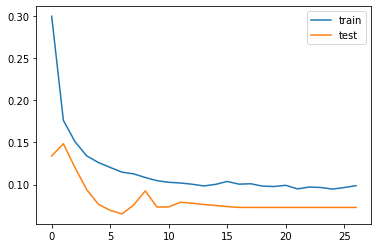

In [42]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [45]:
# load best rnn model
rnn_best_model = keras.models.load_model(filepath)

In [ ]:
# report error
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.04625543658630555
test MAE error for standard averaging: 0.04963793676829961


In [46]:
# report error
train_pred = rnn_best_model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = rnn_best_model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.06704714506226643
test MAE error for standard averaging: 0.06396038036283566


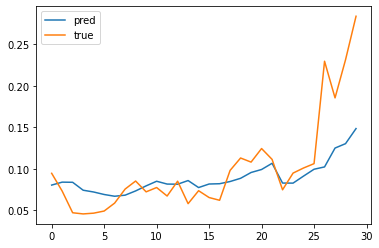

In [105]:
plt.plot(test_pred, label='pred')
plt.plot(y_train[-LAST_N_DAYS:,:], label='true')
plt.legend()
plt.show()

In [65]:
# report error
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.05534402438482259
test MAE error for standard averaging: 0.038487248900289386


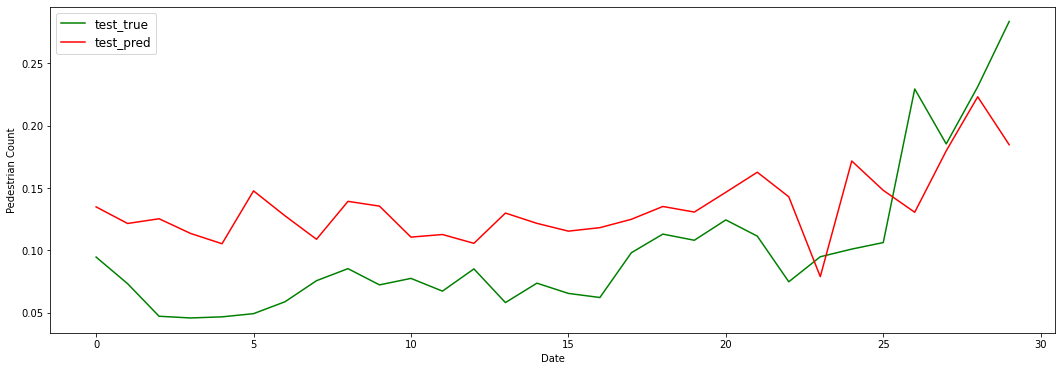

In [ ]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')
plt.legend(fontsize=12)
plt.show()

train MAE error for standard averaging: 0.05534402438482259
test MAE error for standard averaging: 0.038487248900289386


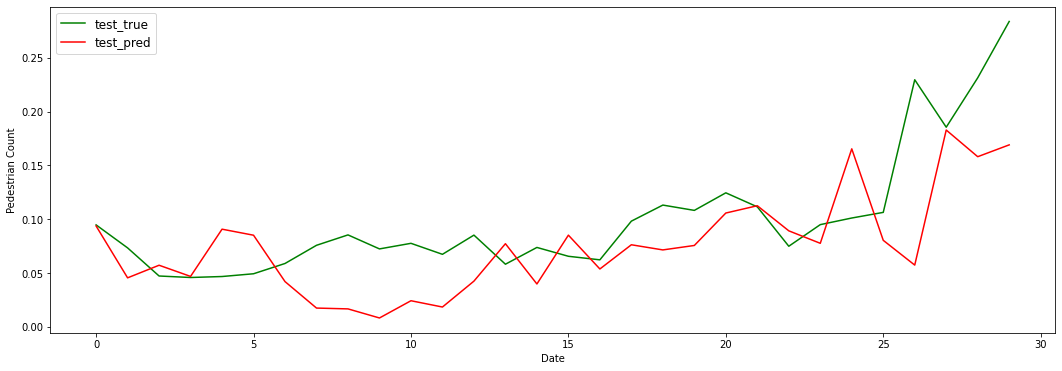

In [66]:
# report error
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')
plt.legend(fontsize=12)
plt.show()

In [ ]:
test_scaled = df.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
scaler.inverse_transform(test_scaled)[-LAST_N_DAYS:,-1]

# LSTM

Add LSTM model here

In [80]:
def get_lstm_model():
  np.random.seed(37)
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(512))
  model.add(Dropout(0.3))
  model.add(Dense(128))
  model.add(Dense(1))
  return model

model = get_lstm_model()
opt = Adam(lr=1e-4)
model.compile(optimizer=opt, loss='mae')

model_history = model.fit(
                            train_x, train_y, 
                            epochs=100, 
                            batch_size=64, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [early_stopping, reduce_lr_on_plateau]
                        )

Epoch 1/100
25/25 [==============================] - 2s 29ms/step - loss: 0.3756 - val_loss: 0.1106
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0977 - val_loss: 0.0623
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0747 - val_loss: 0.0633
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0705 - val_loss: 0.0632
Epoch 5/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0736 - val_loss: 0.0608
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0766 - val_loss: 0.0652
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0748 - val_loss: 0.0617
Epoch 8/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0720 - val_loss: 0.0604
Epoch 9/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0696 - val_loss: 0.0621
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0715 - val_loss: 0.0613

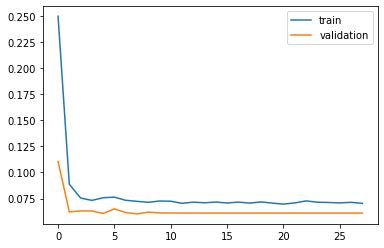

In [82]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [83]:
# report error
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.06483747427761659
test MAE error for standard averaging: 0.02680290353680014


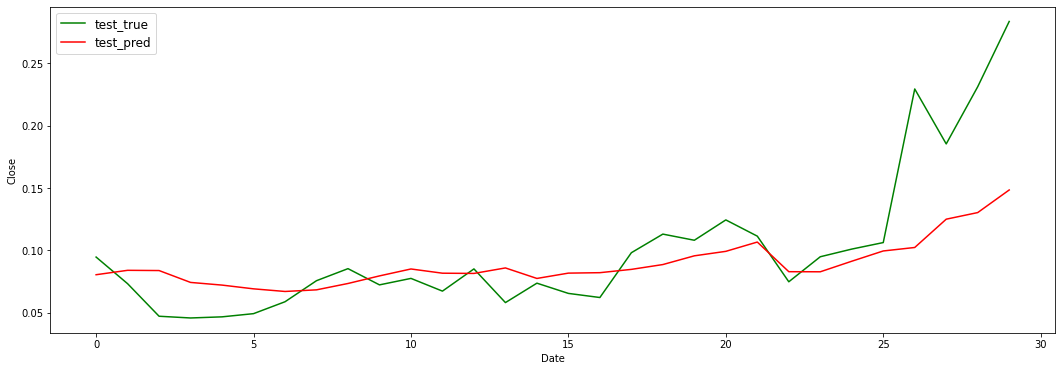

In [84]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(fontsize=12)
plt.show()

In [90]:
test_scaled = df.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
scaler.inverse_transform(test_scaled)[-LAST_N_DAYS:,-1]

,Daily global solar exposure (MJ/m*m),Covid Restrictions,Rainfall amount (millimetres),Public_Holiday,Maximum temperature (Degree C),Minimum temperature (Degree C),target
2102,0.653374,1.0,0.000000,0.0,0.492754,0.445255,0.080476
2103,0.585890,1.0,0.000000,0.0,0.591304,0.613139,0.084010
2104,0.236196,1.0,0.000000,0.0,0.594203,0.470803,0.083826
2105,0.202454,1.0,0.213287,0.0,0.107246,0.310219,0.074298
2106,0.156442,1.0,0.031469,0.0,0.104348,0.302920,0.072151
2107,0.242331,1.0,0.059441,0.0,0.237681,0.346715,0.069150
2108,0.276074,1.0,0.101399,0.0,0.228986,0.394161,0.067042
2109,0.349693,1.0,0.027972,0.0,0.223188,0.405109,0.068346
2110,0.521472,1.0,0.000000,0.0,0.301449,0.372263,0.073446
2111,0.613497,1.0,0.000000,0.0,0.202899,0.397810,0.079531
